In [1]:
import numpy as np
import time
from scipy import optimize as opt
from matplotlib import pyplot as plt

In [2]:
# Set parameters
β = 0.96 ** 20
σ = 3
nvec = np.array([1, 1, 0.2])
A = 1
α = 0.35
δ = 0.6415
toler = 1e-9
L = np.sum(nvec)
T = 20
ξ = 0.2
ϵ = 1e-9

# Define useful functions
U = lambda c: c ** ((1 - σ) - 1) / (1 - σ)  # CRRA utility function
MU = lambda c: c ** (-σ)  # marginal utility
get_r = lambda α, A, L, K, δ: α * A * (L / K) ** (1 - α) - δ
get_w = lambda α, A, L, K: (1 - α) * A * (K / L) ** α

# Exercise 2.1

In [3]:
# Returns whether the initial guess for b2 and b3 violate any constraints
def feasible(f_params, bvec_guess):
    nvec, A, α, δ = f_params
    L = np.sum(nvec)
    K = np.sum(bvec_guess)
    
    r = get_r(α, A, L, K, δ)  # Steady state interest rate
    w = get_w(α, A, L, K)  # Steady state wage
    
    b2, b3 = bvec_guess
    n1, n2, n3 = nvec
    
    # Captial constraint
    K_cnstr = np.sum(bvec_guess) <= 0
    
    # Consumption constraint
    c_cnstr = np.empty(3, dtype=bool)
    c_cnstr[0] = (n1 * w - b2 <= 0)
    c_cnstr[1] = (n2 * w + (1 + r) * b2 - b3 <= 0)
    c_cnstr[2] = (n3 * w + (1 + r) * b3 <= 0)
    
    # Savings constraint
    b_cnstr = np.empty(2, dtype=bool)
    b_cnstr[0] = ((c_cnstr[0] == True) | (c_cnstr[1] == True))
    b_cnstr[1] = ((c_cnstr[1] == True) | (c_cnstr[2] == True))

    return b_cnstr, c_cnstr, K_cnstr

In [4]:
f_params = (nvec, A, α, δ)

#### 2.7.a

In [5]:
bvec_guess = np.array([1.0, 1.2])
feasible(f_params, bvec_guess)

(array([ True, False]), array([ True, False, False]), False)

The household budget constraint in period 1 is violated.

#### 2.7.b

In [6]:
bvec_guess = np.array([0.06, -0.001])
feasible(f_params, bvec_guess)

(array([False, False]), array([False, False, False]), False)

None of the constraints are violated.

#### 2.7.c

In [7]:
bvec_guess = np.array([0.1, 0.1])
feasible(f_params, bvec_guess)

(array([False, False]), array([False, False, False]), False)

None of the constraints are violated.

# Exercise 2.2

In [8]:
# Returns Euler errors from the resulting steady-state
def euler_errors_ss(bvec, params):
    β, α, A, nvec, δ, σ = params
    b2, b3 = bvec
    K = np.sum(bvec)
    n1, n2, n3 = nvec
    L = np.sum(nvec)
    r = get_r(α, A, L, K, δ)
    w = get_w(α, A, L, K)
    err1 = β * (1 + r) * MU(n2 * w + (1 + r) * b2 - b3) - MU(n1 * w - b2)  # Euler equation in period 1
    err2 = β * (1 + r) * MU(n3 * w + (1 + r) * b3) - MU(n2 * w + (1 + r) * b2 - b3) # Euler equation in period 2
    return err1, err2

In [9]:
# Finds steady-state
def get_SS(params, bvec_guess, SS_graphs=False):
    
    start_time = time.clock()
    β, σ, nvec, L, A, α, δ, toler = params 
    K = np.sum(bvec_guess)
    b2, b3 = bvec_guess
    n1, n2, n3 = nvec
    
    # find b1 and b2 to minimize Euler errors
    solution = opt.root(euler_errors_ss, bvec_guess, args=[β, α, A, nvec, δ, σ], tol=toler)
    
    b_ss = solution.x  # steady-state savings
    K_ss = np.sum(b_ss)  # steady-state capital stock
    r_ss = get_r(α, A, L, K_ss, δ)  # steady-state interest rate
    w_ss = get_w(α, A, L, K_ss)  # steady-state wage
    
    c1 = n1 * w_ss - b_ss[0]  # steady-state consumption in period 1
    c2 = n2 * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]  # steady-state consumption in period 2
    c3 = n3 * w_ss + (1 + r_ss) * b_ss[1]  # steady-state consumption in period 3
    c_ss = np.array([c1, c2, c3])
    C_ss = np.sum(c_ss)  # total consumption in steady-state 
    
    Y_ss = C_ss + K_ss - (1 - δ) * K_ss  # total output in steady-state 
    
    EulErr_ss = solution.fun
    RCerr_ss = Y_ss - C_ss - δ * K_ss
    ss_time = time.clock() - start_time
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    
    if SS_graphs:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].bar([1, 2, 3], c_ss)
        axes[0].set_xticks([1, 2, 3])
        axes[0].set_xticklabels(['Young', 'Middle Age', 'Elderly'])
        axes[0].set_title('Steady-State Distribution of Consumption by Age')
        
        axes[1].bar([1, 2], b_ss)
        axes[1].set_xticks([1, 2])
        axes[1].set_xticklabels(['Young', 'Middle Age'])
        axes[1].set_title('Steady-State Distribution of Savings by Age')
        plt.show()
        
    return ss_output

In [10]:
params = (β, σ, nvec, L, A, α, δ, toler)

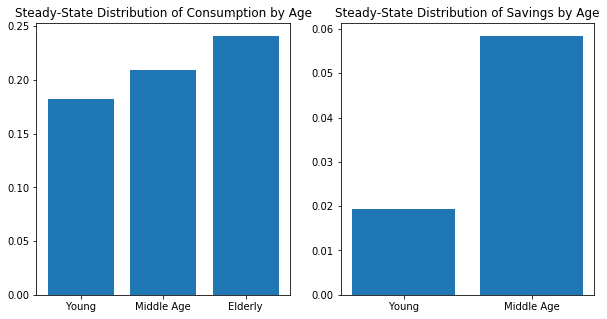

{'C_ss': 0.6329021499791027,
 'EulErr_ss': array([ 1.39266376e-12, -2.64321898e-12]),
 'K_ss': 0.07772423282525998,
 'RCerr_ss': 4.85722573273506e-17,
 'Y_ss': 0.682762245336507,
 'b_ss': array([0.01931272, 0.05841151]),
 'c_ss': array([0.18241249, 0.20961516, 0.2408745 ]),
 'r_ss': 2.4330467299114265,
 'ss_time': 0.000652000000000097,
 'w_ss': 0.20172520884942252}

In [11]:
bvec_guess = np.array([0.1, 0.1])
get_SS(params, bvec_guess, SS_graphs=True)

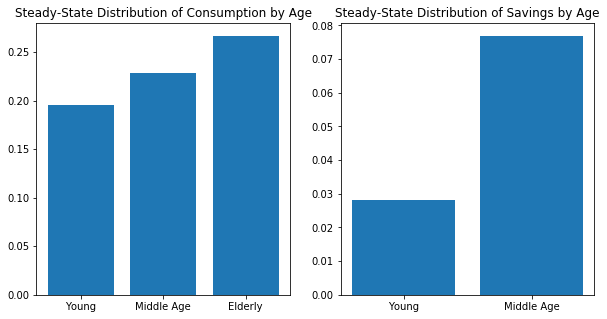

{'C_ss': 0.6912842903551415,
 'EulErr_ss': array([-5.68434189e-14,  2.84217094e-14]),
 'K_ss': 0.10504237022597478,
 'RCerr_ss': 1.3877787807814457e-17,
 'Y_ss': 0.7586689708551043,
 'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': array([0.19597528, 0.22861594, 0.26669307]),
 'r_ss': 1.8863765057190747,
 'ss_time': 0.0005589999999999762,
 'w_ss': 0.22415219593446262}

In [12]:
params = ((0.55, σ, nvec, L, A, α, δ, toler))
bvec_guess = np.array([0.1, 0.1])
get_SS(params, bvec_guess, SS_graphs=True)

An increase in $\beta$ increases consumption and savings in every period. Wages increase as well, while interest rates decrease. Increasing the discount rate means that households can maximize lifetime utility by consuming more in future periods. Savings for future periods, as well as consumption in these periods, will therefore increase, while interest rates will decrease with this increase in savings. This saving will also result in an increase in overall output, which will increase wages as well as allow for households to consume more in every period, including the t=1 period.

# Exercise 2.3

In [13]:
# solve for steady state 
params = (β, σ, nvec, L, A, α, δ, toler)
bvec_guess = np.array([0.1, 0.1])
SS = get_SS(params, bvec_guess)

nvec = np.array([1, 1, 0.2])
n1, n2, n3 = nvec

# steady-state savings
bvec_ss = SS['b_ss']
b2_ss = bvec_ss[0]
b3_ss = bvec_ss[1]
K_ss = np.sum(bvec_ss)

# set initial conditions
b2_0 = 0.8 * b2_ss
b3_0 = 1.1 * b3_ss
bvec_0 = np.array([b2_0, b3_0])
K_0 = np.sum(bvec_0)

In [14]:
# define Euler equations
euler_b2 = lambda b2, b3, w1, w2, r2: β * (1 + r2) * MU(n2 * w2 + (1 + r2) * b2 - b3) - MU(n1 * w1 - b2)
euler_b3 = lambda b3, b2, w2, w3, r2, r3: β * (1 + r3) * MU((1 + r3) * b3 + n3 * w3) - MU(n2 * w2 + (1 + r2) * b2 - b3)

In [15]:
# get Euler equation to solve for b2 and b3
def get_b2_b3(bvec, w1, w2, w3, r2, r3):
    
    b2, b3 = bvec
    b2_euler = euler_b2(b2, b3, w1, w2, r2)
    b3_euler = euler_b3(b3, b2, w2, w3, r2, r3)
    
    return np.array([b2_euler, b3_euler]).flatten()

In [16]:
# get Euler equation to solve for b32
def get_b32(b3, b2, w1, w2, r1, r2):
    return euler_b3(b3, b2, w1, w2, r1, r2)

In [17]:
# Compute time paths of capital stock, wage, interest rate
def find_path(T, bvec_0, nvec, m, params):

    σ, β, ξ, ϵ, δ = params
    n1, n2, n3 = nvec
    
    # guess path of capital stock, interest rates, and wages
    K_path = np.linspace(K_0, K_ss, T + 5 + m)
    r_path = get_r(α, A, L, K_path, δ)
    w_path = get_w(α, A, L, K_path)
    
    # initialize b matrix
    bmat = np.zeros((T + 5 + m, 2))
    bmat[0, :] = bvec_0
    b21, w1, w2, r1, r2 = bvec_0[0], w_path[0], w_path[1], r_path[0], r_path[1]
    bmat[1, 1] = opt.root(get_b32, 0, args=(b21, w1, w2, r1, r2)).x  # find optimal b32
    
    i = 0
    max_iter = 100
    dist = 1000
    Eul_errs = np.empty((T + 5 + m, 2))
    Y_path = np.empty((T + 4 + m, 2))
    Rcc_path = np.empty((T + 4 + m, 2))
    
    # iterate until K_path converges within a tolerance ϵ
    while (dist > ϵ) and (i < max_iter):
        for t in range(1, T + 4 + m):
            w1, w2, w3 = w_path[t - 1], w_path[t], w_path[t + 1]
            r2, r3 = r_path[t], r_path[t + 1]
            solution = opt.root(get_b2_b3, np.zeros(2), args=(w1, w2, w3, r2, r3))  # find optimal b2 and b3
            b2, b3 = solution.x
            bmat[t, 0] = b2
            bmat[t + 1, 1] = b3
            Eul_errs[t-1] = solution.fun
        
        # recalculate K_path
        K_path_prime = bmat.sum(axis=1)
        dist = ((K_path_prime - K_path) ** 2).sum()
        K_path = ξ * K_path_prime + (1 - ξ) * K_path
        
        # recalculate r_path, w_path
        r_path = get_r(α, A, L, K_path, δ)  
        w_path = get_w(α, A, L, K_path)
        
        i += 1
    
    # compute for time paths for consumption, savings
    b2_path = bmat[:, 0]
    b3_path = bmat[:, 1]
    c1_path = n1 * w_path - b2_path  # steady-state consumption in period 1
    c2_path = n2 * w_path + (1 + r_path) * b2_path - b3_path  # steady-state consumption in period 2
    c3_path = n3 * w_path + (1 + r_path) * b3_path  # steady-state consumption in period 3
    c_paths = np.array([c1_path, c2_path, c3_path])
    C_path = np.sum(c_paths, axis=0)  # total consumption in steady-state 
    
    Y_path = C_path + K_path - (1 - δ) * K_path
    Rc_path = Y_path[:-1] - C_path[:-1] - K_path[1:] + (1 - δ) * K_path[:-1]
    
    return K_path[:-m], w_path[:-m], r_path[:-m], Eul_errs[:-m], Rc_path[:-m+1]

In [18]:
K_path, w_path, r_path, Eul_errs, Rc_path = find_path(T, bvec_0, nvec, 3, (σ, β, ξ, ϵ, δ))

In [19]:
print("Max Euler error:", np.max(np.abs(Eul_errs)))

Max Euler error: 3.7790641727042384e-09


In [20]:
print("Max Resourse constraint error:", np.max(np.abs(Rc_path)))

Max Resourse constraint error: 0.0038166065475618016


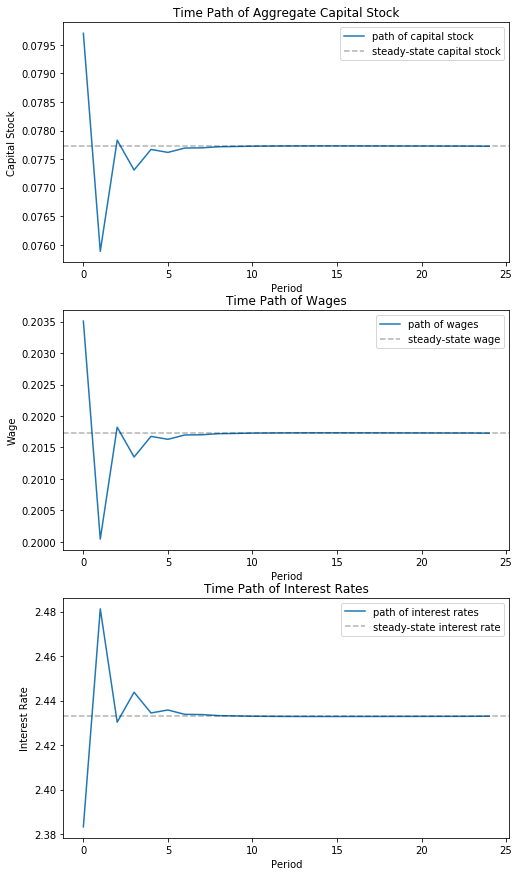

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(8, 15))
axes[0].plot(K_path, label='path of capital stock')
axes[0].axhline(SS['K_ss'], ls='--', c='k', alpha=0.3, label='steady-state capital stock')
axes[0].set_title('Time Path of Aggregate Capital Stock')
axes[0].set_ylabel('Capital Stock')
axes[0].set_xlabel('Period')
axes[0].legend()

axes[1].plot(w_path, label='path of wages')
axes[1].axhline(SS['w_ss'], ls='--', c='k', alpha=0.3, label='steady-state wage')
axes[1].set_title('Time Path of Wages')
axes[1].set_ylabel('Wage')
axes[1].set_xlabel('Period')
axes[1].legend()

axes[2].plot(r_path, label='path of interest rates')
axes[2].axhline(SS['r_ss'], ls='--', c='k', alpha=0.3, label='steady-state interest rate')
axes[2].set_title('Time Path of Interest Rates')
axes[2].set_ylabel('Interest Rate')
axes[2].set_xlabel('Period')
axes[2].legend()

plt.show()

In [22]:
np.argwhere(np.abs(K_ss - K_path) < 0.00001)[0]

array([8])

The economy gets within 0.00001 of the steady state aggregate capital stock after 9 periods. 